In [1]:
%matplotlib inline
import os
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math

In [2]:
def print_image(img, cm=None):
    plt.figure()
    plt.imshow(img, cmap=cm)

def save_image(path, img_arr):
    img_res = Image.fromarray(img_arr)
    img_res.save(path)
    
def read_image(path, conv=None):
    img = Image.open(path)
    if conv != None:
        img = img.convert(conv)
    return np.array(img)

def list_dir_files(root_path):
    filenames = []
    for (path, dirs, files) in os.walk(root_path):
        for filename in files:
            fullpath = os.path.join(path, filename)
            filenames.append(filename)
    return filenames

In [3]:
def build_hist(min_ind, max_ind, values):
    hist = np.array([0] * (max_ind - min_ind + 1))
    for elem in values:
        hist[elem - min_ind] += 1
    return hist

def plot_barchart(ind, val, width):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    rects = ax.bar(ind, val, width)
    plt.show()

In [4]:
def threshold_otsu(hist, min_lum, max_lum):    
    alpha_sum = 0 # sum of bins multiplied by the their middle
    beta_sum = 0 # sum of bins
    for i in xrange(len(hist)):
        alpha_sum += i * hist[i]
        beta_sum += hist[i]
    max_sigma = -1.0 # max variance
    threshold = 0

    alpha_1 = 0 # sum of bins multiplied by the their middle for the first class
    beta_1 = 0 # sum of bins for the first class
    means_1 = 0.0
    means_2 = 0.0

    for i in xrange(len(hist) - 1):
        alpha_1 += i * hist[i]
        beta_1 += hist[i]

        prob1 = float(beta_1) / beta_sum # probability of the first class
        is_denom_1_zero = beta_1 == 0
        is_denom_2_zero = beta_sum - beta_1 == 0
        if not is_denom_1_zero and not is_denom_2_zero:
            average_diff = float(alpha_1) / beta_1 - float(alpha_sum - alpha_1) / (beta_sum - beta_1)
            sigma = prob1 * (1 - prob1) * (average_diff ** 2)
        else:
            sigma = max_sigma

        if sigma >= max_sigma:
            max_sigma = sigma
            if not is_denom_1_zero:
                means_1 = float(alpha_1) / beta_1
            else:
                means_1 += 1
            if not is_denom_2_zero:
                means_2 = float(alpha_sum - alpha_1) / (beta_sum - beta_1)
            else:
                means_2 -= 1
            threshold = i

    threshold += min_lum
    means_1 += min_lum
    means_2 += min_lum
    return (threshold, means_1, means_2)

In [5]:
# http://ijsetr.com/uploads/513462IJSETR8347-2029.pdf
# http://aircconline.com/cseij/V6N1/6116cseij01.pdf
def threshold_triclass(hist, min_lum, max_lum):
    eps = 0.1
    threshold, means1, means2 = threshold_otsu(hist, min_lum, max_lum)
    threshold_prev = threshold + 3
    while abs(threshold - threshold_prev) > eps:
        left_index = int(math.ceil(means1))
        right_index = int(math.floor(means2))
        threshold_prev = threshold
        threshold, means1, means2 = threshold_otsu(hist[left_index : right_index + 1], means1, means2 + 1)
    return (threshold, means1, means2)

In [6]:
def binarize_threshold(img_arr, threshold):    
    res = np.zeros(img_arr.shape)
    for i in xrange(len(img_arr)):
        for j in xrange(len(img_arr[i])):
            if img_arr[i][j] > threshold:
                res[i][j] = 255
    return res

In [7]:
# http://www.sciencedirect.com/science/article/pii/S1319157812000444

def count_recall_coefs(real_img, test_img):
    test_img = test_img.astype(int) / 255
    real_img = real_img.astype(int) / 255
    test_img_inv = np.ones(test_img.shape, dtype=int) - test_img
    real_img_inv = np.ones(real_img.shape, dtype=int) - real_img

    tp = np.sum(np.multiply(test_img_inv, real_img_inv)) # test black - real black
    fp = np.sum(np.multiply(test_img_inv, real_img    )) # test black - real white
    fn = np.sum(np.multiply(test_img    , real_img_inv)) # test white - real black
    return (tp, fp, fn)

# Recall Score (returns 1 if equal)
def recall_score(real_img, test_img):
    tp, fp, fn = count_recall_coefs(real_img, test_img)
    recall = 1.0 * tp / (tp + fn)
    return recall

# Precision Score (returns 1 if equal)
def precision_score(real_img, test_img):
    tp, fp, fn = count_recall_coefs(real_img, test_img)
    precision = 1.0 * tp / (tp + fp)
    return precision
    

# F-Score (returns 1 if equal)
def f_score(real_img, test_img):
    if test_img.shape != real_img.shape:
        raise ValueError('Shapes are different')
    
    recall = recall_score(real_img, test_img)
    precision = precision_score(real_img, test_img)
    return (2 * recall * precision) / (recall + precision)

In [8]:
# PSNR (returns infinity if equal)
def psnr_measure(img1, img2):
    if img1.shape != img2.shape:
        raise ValueError('Shapes are different')
    c = 255
    diff_matr = img1.astype(int) - img2.astype(int)
    mse = np.sum(np.square(diff_matr)) * 1.0 / np.prod(img1.shape)
    return 10 * math.log10(c ** 2 / mse)

In [9]:
# SAD - Sum of absolute differences (returns 0 if equal)
def sad_measure(img1, img2):
    if img1.shape != img2.shape:
        raise ValueError('Shapes are different')
    diff_matr = np.absolute(img1.astype(int) - img2.astype(int)) / 255
    return np.sum(diff_matr)

In [11]:
# Apply all those functions to real images
dir_input = 'OriginalImages/'
dir_output_otsu = 'ResImagesOtsu/'
dir_output_ttt  = 'ResImagesTTT/'
dir_test   = 'GTimages/'
filenames = list_dir_files(dir_input)
frame_cols = ['SAD', 'Recall', 'Precision', 'F-Score', 'PSNR']
frame_res_otsu = pd.DataFrame(columns=frame_cols, index=filenames)
frame_res_ttt  = pd.DataFrame(columns=frame_cols, index=filenames)

for i in xrange(len(filenames)):
    img_arr = read_image(dir_input + filenames[i], 'L')

    min_lum = np.min(img_arr)
    max_lum = np.max(img_arr)

    hist = build_hist(min_lum, max_lum, img_arr.flatten())
    
    thresh_otsu = threshold_otsu(hist, min_lum, max_lum)[0]
    thresh_ttt = threshold_triclass(hist, min_lum, max_lum)[0]

    img_binarized_otsu = binarize_threshold(img_arr, thresh_otsu).astype(np.uint8)
    save_image(dir_output_otsu + filenames[i], img_binarized_otsu)
    img_binarized_ttt  = binarize_threshold(img_arr, thresh_ttt ).astype(np.uint8)
    save_image(dir_output_ttt  + filenames[i], img_binarized_ttt )

    img_test_name = filenames[i].split('.')[0] + '_estGT.tiff'
    img_test = read_image(dir_test  + img_test_name, 'L')
    
    frame_res_otsu.loc[filenames[i]] = {
        'SAD': sad_measure(img_binarized_otsu, img_test),
        'Recall': recall_score(img_binarized_otsu, img_test),
        'Precision': precision_score(img_binarized_otsu, img_test),
        'F-Score': f_score(img_binarized_otsu, img_test),
        'PSNR': psnr_measure(img_binarized_otsu, img_test)
    }
    frame_res_ttt.loc[filenames[i]] = {
        'SAD': sad_measure(img_binarized_ttt, img_test),
        'Recall': recall_score(img_binarized_ttt, img_test),
        'Precision': precision_score(img_binarized_ttt, img_test),
        'F-Score': f_score(img_binarized_ttt, img_test),
        'PSNR': psnr_measure(img_binarized_ttt, img_test)
    }
    
print 'Otsu results:'
print frame_res_otsu
print '\nTriclass Thresholding Technique:'
print frame_res_ttt
# ~3 min

Otsu results:
              SAD    Recall Precision   F-Score     PSNR
PR06.bmp   116863   0.62336  0.975211  0.760563  11.5677
PR08.bmp    41808  0.640801  0.882699  0.742546  12.7945
PR04.bmp   472331  0.340473  0.981543  0.505575  6.22827
PR01.bmp    17987  0.907573   0.85113  0.878446  19.2186
HW06.tiff   41125  0.909164  0.918907  0.914009  19.3702
HW02.bmp     8931  0.946626  0.837594  0.888778  18.5189
HW04.bmp    17148  0.955778  0.944137  0.949922  23.2411
HW05.bmp   108422  0.408034   0.99762  0.579179  13.4658
PR07.bmp     8481  0.970931  0.902418  0.935422   15.786
HW07.bmp    26177  0.991325  0.259428  0.411237  17.6839
HW08.tiff   20565  0.934115  0.927873  0.930984  20.8131
PR05.bmp    50454  0.795438  0.963656  0.871504  12.8194
PR02.bmp    11213  0.957923  0.941522  0.949652  20.4989
PR03.bmp    14549   0.99605  0.828786  0.904752   18.939
HW01.bmp    51004   0.97774  0.717418   0.82759  19.3237
HW03.bmp    31215  0.952008  0.621571  0.752095   15.679

Triclass Thresho

PR06.bmp
PR08.bmp
PR04.bmp
PR01.bmp
HW06.tiff
HW02.bmp


/home/andrejsautin/ProgramFiles/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


HW04.bmp
HW05.bmp
PR07.bmp
HW07.bmp
HW08.tiff
PR05.bmp
PR02.bmp
PR03.bmp
HW01.bmp
HW03.bmp


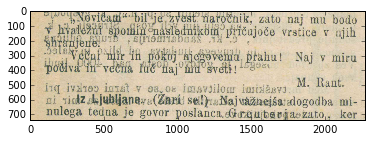

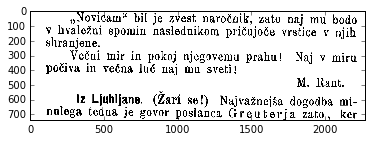

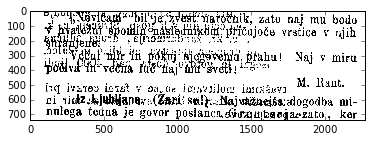

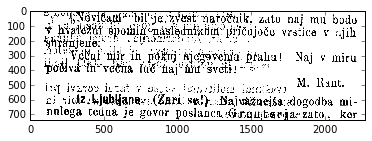

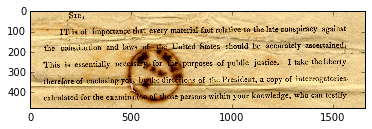

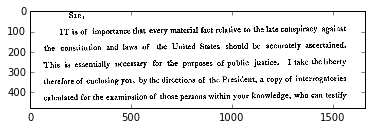

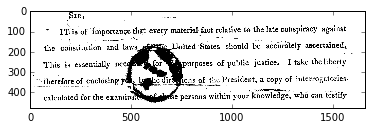

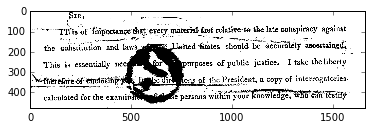

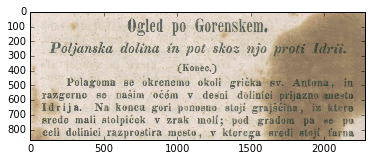

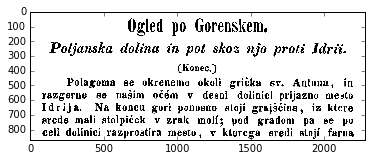

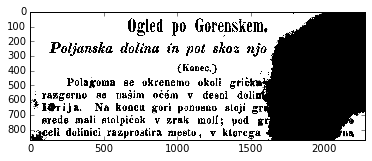

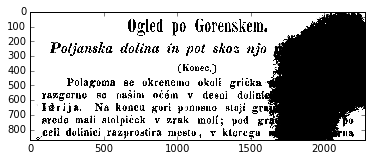

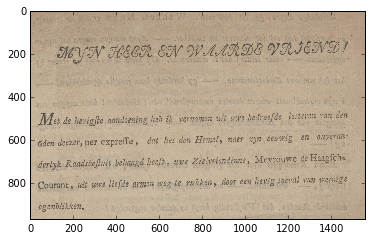

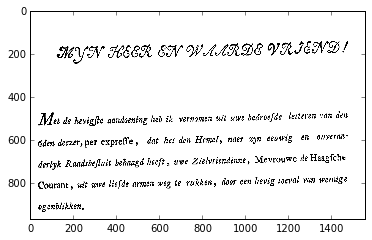

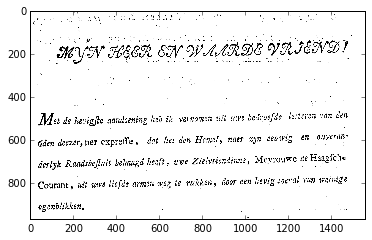

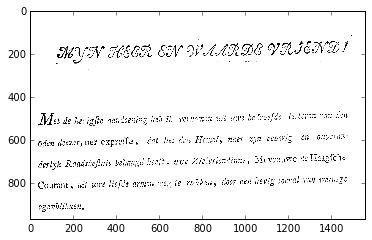

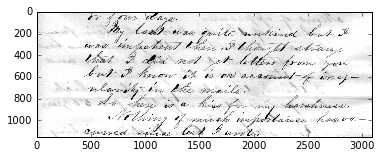

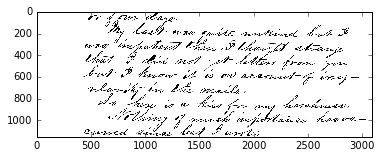

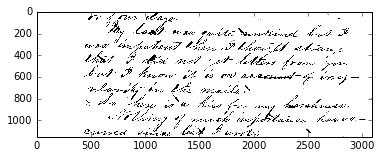

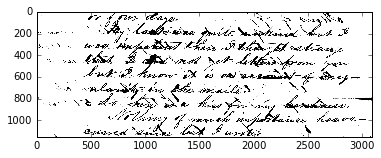

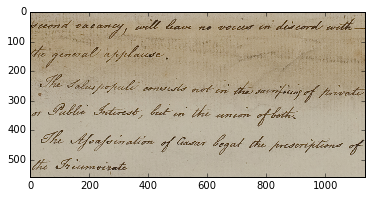

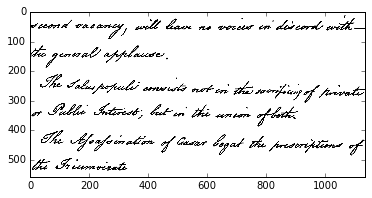

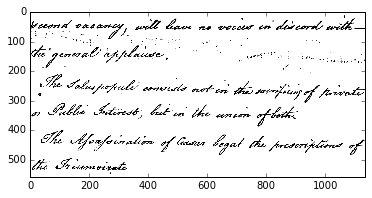

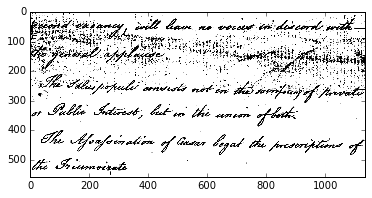

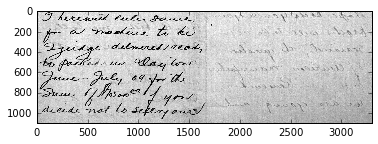

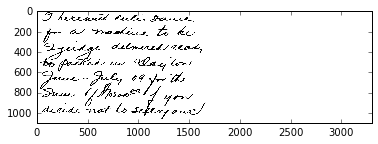

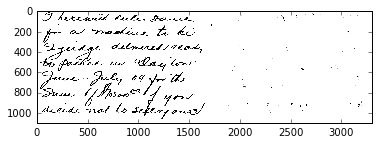

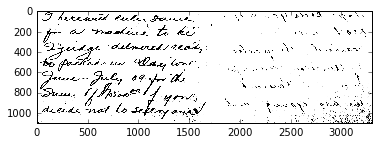

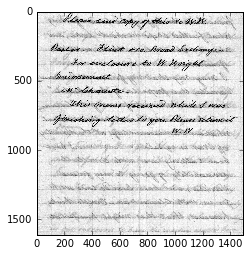

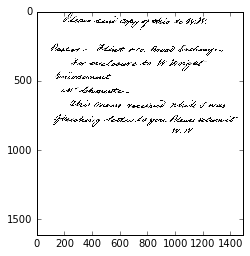

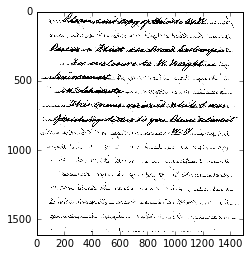

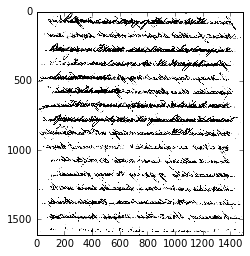

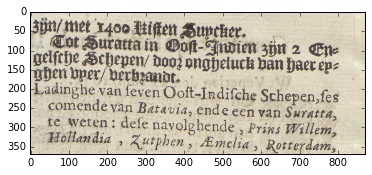

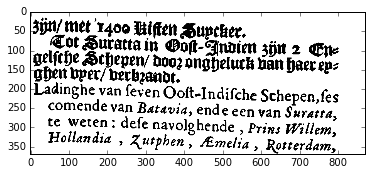

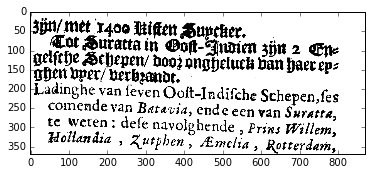

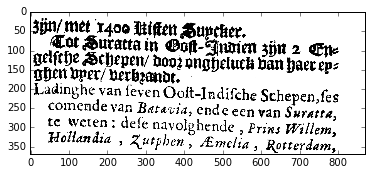

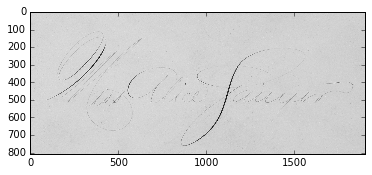

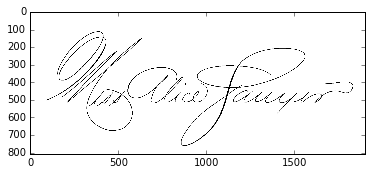

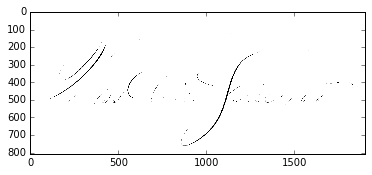

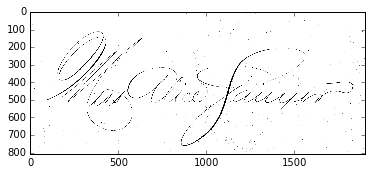

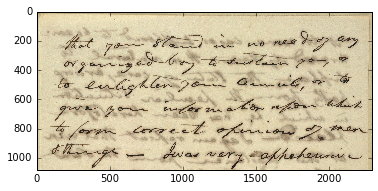

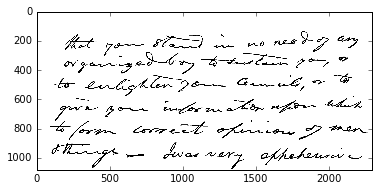

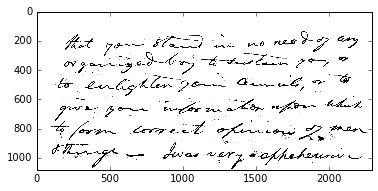

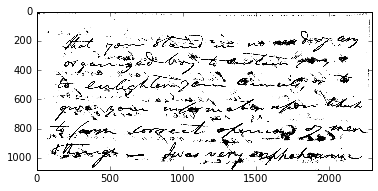

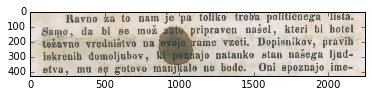

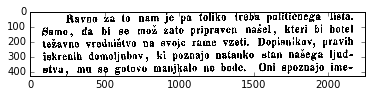

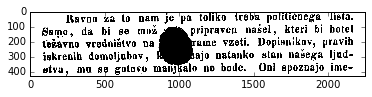

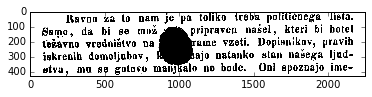

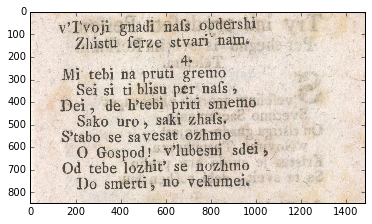

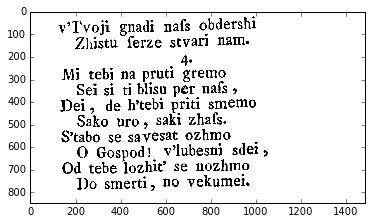

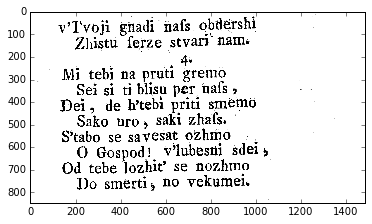

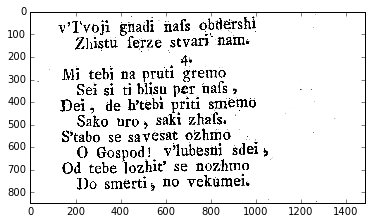

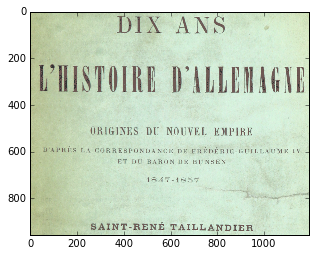

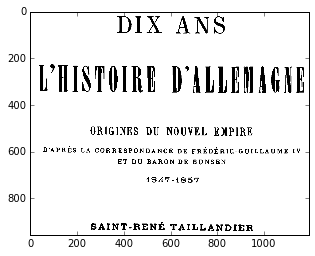

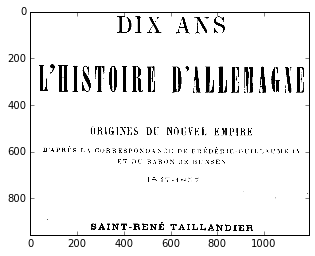

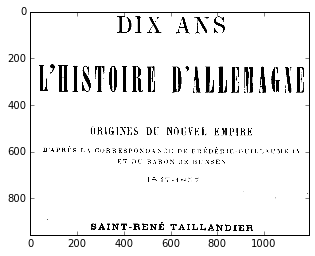

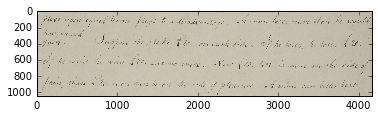

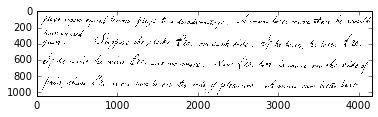

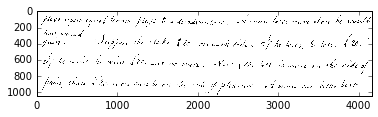

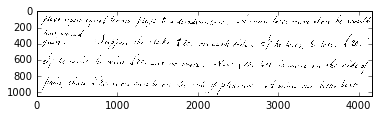

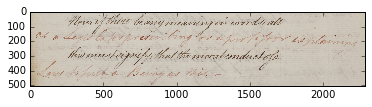

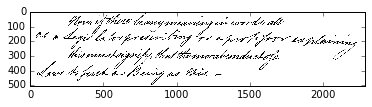

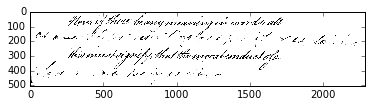

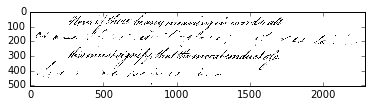

In [12]:
for filename in filenames:
    img_test_name = filename.split('.')[0] + '_estGT.tiff'
    
    print filename
    img_test = read_image(dir_test  + img_test_name, 'L')
    img_original = read_image(dir_input + filename)
    img_otsu = read_image(dir_output_otsu + filename, 'L')
    img_ttt  = read_image(dir_output_ttt  + filename, 'L')
    print_image(img_original)
    print_image(img_test, 'Greys_r')
    print_image(img_otsu, 'Greys_r')
    print_image(img_ttt, 'Greys_r')
    